# Fine-Tuning
In earlier chapters, we discussed how to train models on the Fashion-MNIST training dataset, which only has 60,000 images. We also described ImageNet, the most widely used large-scale image dataset in the academic world, with more than 10 million images and objects of over 1000 categories. However, the size of datasets that we often deal with is usually larger than the first, but smaller than the second.

Assume we want to identify different kinds of chairs in images and then push the purchase link to the user. One possible method is to first find a hundred common chairs, take one thousand different images with different angles for each chair, and then train a classification model on the collected image dataset. Although this dataset may be larger than Fashion-MNIST, the number of examples is still less than one tenth of ImageNet. This may result in the overfitting of the complicated model applicable to ImageNet on this dataset. At the same time, because of the limited amount of data, the accuracy of the final trained model may not meet the practical requirements.

In order to deal with the above problems, an obvious solution is to collect more data. However, collecting and labeling data can consume a lot of time and money. For example, in order to collect the ImageNet datasets, researchers have spent millions of dollars of research funding. Although, recently, data collection costs have dropped significantly, the costs still cannot be ignored.

Another solution is to <font color=red>apply transfer learning to migrate the knowledge learned from the source dataset to the target dataset</font>. For example, although the images in ImageNet are mostly unrelated to chairs, models trained on this dataset can extract more general image features that can help identify edges, textures, shapes, and object composition. These similar features may be equally effective for recognizing a chair.

In this section, we introduce a common technique in transfer learning: fine tuning. <font color=red>Fine tuning consists of the following four steps:</font>

1. Pre-train a neural network model, i.e., the source model, on a source dataset (e.g., the ImageNet dataset).

2. Create a new neural network model, i.e., the target model. This replicates all model designs and their parameters on the source model, except the output layer. We assume that these model parameters contain the knowledge learned from the source dataset and this knowledge will be equally applicable to the target dataset. We also assume that the output layer of the source model is closely related to the labels of the source dataset and is therefore not used in the target model.

3. Add an output layer whose output size is the number of target dataset categories to the target model, and randomly initialize the model parameters of this layer.

4. Train the target model on a target dataset, such as a chair dataset. We will train the output layer from scratch, while the parameters of all remaining layers are fine-tuned based on the parameters of the source model.

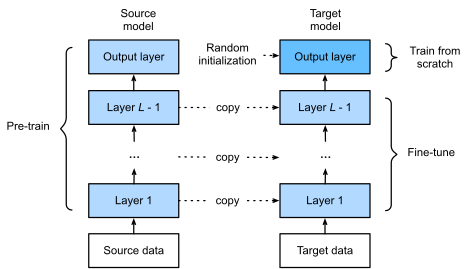

In [1]:
from IPython.display import SVG
SVG(filename="../img/finetune.svg")

# Hot Dog Recognition
Next, we will use a specific example for practice: hot dog recognition. We will fine-tune the ResNet model trained on the ImageNet dataset based on a small dataset. This small dataset contains thousands of images, some of which contain hot dogs. We will use the model obtained by fine tuning to identify whether an image contains a hot dog.

First, import the packages and modules required for the experiment.

In [30]:
import torch
from torch import nn
from torch import optim
from torch.utils.data import DataLoader
from torch.autograd import Variable

import torchvision

import os
import numpy as np
import matplotlib.pyplot as plt
import sys
sys.path.insert(0, '..')
import d2l

### Obtain the Dataset
The hot dog dataset we use was taken from online images and contains  1,400  positive images containing hot dogs and the same number of negative images containing other foods.  1,000  images of various classes are used for training and the rest are used for testing.

In [17]:
from torchvision.datasets.utils import download_and_extract_archive
download_and_extract_archive(url='http://d2l-data.s3-accelerate.amazonaws.com/' + 'hotdog.zip',
                            download_root='../data/',
                            extract_root='../data/')

Using downloaded and verified file: ../data/hotdog.zip
Extracting ../data/hotdog.zip to ../data/


In [28]:
normalize = torchvision.transforms.Normalize(
    [0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
train_augs = torchvision.transforms.Compose([
    torchvision.transforms.RandomResizedCrop(224),
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    normalize])

test_augs = torchvision.transforms.Compose([
    torchvision.transforms.Resize(256),
    torchvision.transforms.CenterCrop(224),
    torchvision.transforms.ToTensor(),
    normalize])

train_data = torchvision.datasets.ImageFolder(root='../data/hot_dog/train', transform=train_augs)
train_iter = torch.utils.data.DataLoader(train_data,
                                          batch_size=16,
                                          shuffle=True,
                                          num_workers=4)

test_data = torchvision.datasets.ImageFolder(root='../data/hot_dog/test', transform=train_augs)
test_iter = torch.utils.data.DataLoader(test_data, 
                                        batch_size=16,
                                        shuffle=False,
                                        num_workers=4)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


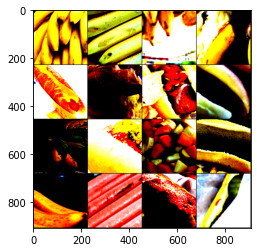

In [24]:
def matplotlib_imshow(img, one_channel=False):
    if one_channel:
        img = img.mean(dim=0)
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        
for images, labels in train_iter:
    break
grid_img = torchvision.utils.make_grid(images, nrow=4) # size: around (C, H*B/nrow, W*nrow)
matplotlib_imshow(grid_img, one_channel=False)

## Define and Initialize the Model
We use ResNet-18, which was pre-trained on the ImageNet dataset, as the source model. Here, we specify pretrained=True to automatically download and load the pre-trained model parameters. The first time they are used, the model parameters need to be downloaded from the Internet.

In [31]:
model = torchvision.models.resnet18(pretrained=True)
for param in model.parameters():
    param.requires_grad = False
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

The given pre-trained ResNet model has an output of 10 classes, so we can see that `(fc): Linear(in_features=512, out_features=1000, bias=True)`. In our task, there are two possible output: yes or no. So we would change the model output as 2. 

In the following code, we update the existing `fc` layer as `model.fc.out_features = 2`. 

In [27]:
# change the number of output features
model.fc.out_features = 2
for param in model.fc.parameters():
    param.requires_grad = True

def weights_init(m):
    if type(m) == nn.Linear:
        nn.init.kaiming_normal(m.weight.data)

model.apply(weights_init)

/opt/anaconda3/envs/dive_into_deep_learning/lib/python3.6/site-packages/ipykernel_launcher.py:8: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.
  


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

<font color=red>Another way is to delete the `fc` layer. Use to method `torch.no_grad()` to freeze the parameters in the pre-trained network. We could add a new Linear layer.
```
model_1 = nn.Sequential(*list(model.children())[:-1])
model_2 = nn.Linear(512, 2, bias=True)
with torch.no_grad():
    X = model_1(X)
y = model_2(X)
```
Then the training process will only update the parameters in `model_2`. Notice that you won't be able to backpropagate the gradient to layers before the no_grad.</font>

In [32]:
new_model = nn.Sequential(*list(model.children())[:-1])
new_model

Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
num_epochs = 10
train_iter, test_iter = load_data(data_path="./data/", batch_size=batch_size)
net = initialize_model(num_classes=2)
net.to(device)

loss = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.fc.parameters(), lr=lr)

if torch.cuda.device_count() >= 1:
    net = nn.DataParallel(net)

result = d2l.train_model(net, loss, optimizer, train_iter, test_iter, num_epochs, device)

d2l.plot_result(result)